In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def a_fb(sqrtshalf,gf):
    MZ = 90
    GFNom = 1.0

    sqrts = sqrtshalf*2.
    A_FB_EN = np.tanh((sqrts-MZ)/MZ*10)
    A_FB_GF = gf/GFNom
    return 2*A_FB_EN*A_FB_GF
    
def diffxsec(costheta,sqrtshalf,gf):
    norm = 2.*((1.+1./3.))
    return ((1+costheta**2)+a_fb(sqrtshalf,gf)*costheta)/norm

In [3]:
def rej_sample_costheta(nsamples,sqrtshalf,gf):
    samples = []
    x = np.linspace(-1,1,num = 1000)
    maxval = np.max(diffxsec(x,sqrtshalf,gf))
    while len(samples) < nsamples:
        xprop  = np.random.uniform(-1,1)
        ycut = np.random.random()
        yprop = diffxsec(xprop,sqrtshalf,gf)/maxval
        if yprop/maxval < ycut:
            continue
        samples.append(xprop)
    return np.array(samples)

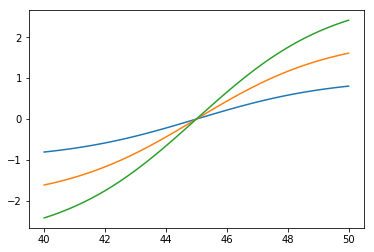

In [4]:
x = np.linspace(40,50,100)
plt.plot(x,a_fb(x,0.5))
plt.plot(x,a_fb(x,1.0))
plt.plot(x,a_fb(x,1.5))

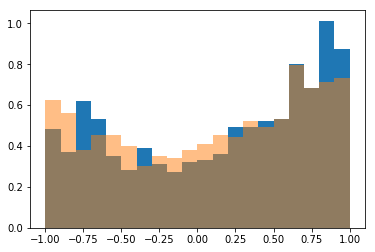

In [5]:
v,b,p = plt.hist(rej_sample_costheta(1000,46,1.5), bins = 20, normed=True)
v,b,p = plt.hist(rej_sample_costheta(1000,46,1.0), bins = b, normed=True, alpha = 0.5)

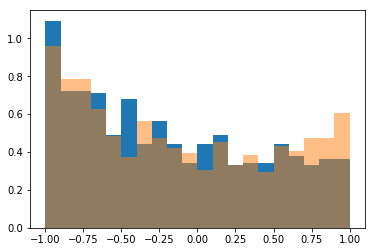

In [6]:
v,b,p = plt.hist(rej_sample_costheta(1000,44,1.5), bins = 20, normed=True)
v,b,p = plt.hist(rej_sample_costheta(1000,44,1.0), bins = b, normed=True, alpha = 0.5)

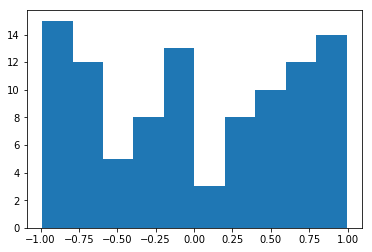

In [7]:
data = rej_sample_costheta(100,44,1.0)
_=plt.hist(data)

In [8]:
import emcee

<Container object of 3 artists>

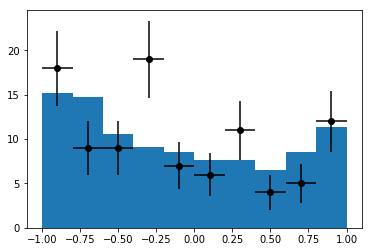

In [9]:
mc = rej_sample_costheta(1000,44,1.0)
data = rej_sample_costheta(100,44,1.0)
mccounts,bins,_ = plt.hist(mc,weights = [float(len(data))/float(len(mc))]*len(mc), bins = np.linspace(-1,1,11))
datacounts,bins = np.histogram(data,bins = bins)
centers = bins[:-1] + (bins[1:]-bins[:-1])/2.
plt.errorbar(centers,datacounts,fmt = 'o',xerr = (bins[1:]-bins[:-1])/2.,yerr = np.sqrt(datacounts), c = 'k')

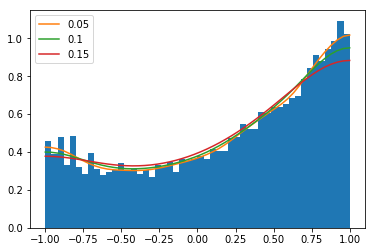

In [10]:
mc = rej_sample_costheta(10000,47,1.0)
mirrored = np.concatenate([(-2-mc),mc,(2-mc)])
from scipy.stats import entropy, gaussian_kde
plt.hist(mc,normed = True, bins = 50)
for bw in np.linspace(0.05,0.15,3):
    kernel = gaussian_kde(mirrored, bw_method=bw)
    xs = np.linspace(-1,1)
    plt.plot(xs, [3*kernel(x) for x in xs], label = bw)

plt.legend()

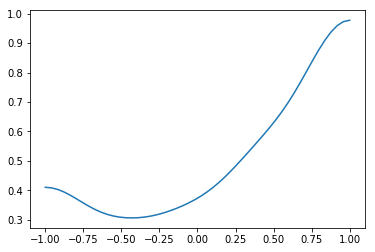

In [11]:
from scipy.stats import entropy, gaussian_kde
def approx_logpdf(mc,bw = 0.1):
    mirrored = np.concatenate([(-2-mc),mc,(2-mc)])
    kernel = gaussian_kde(mirrored, bw_method=bw)
    def func(x):
        return np.log(3)+kernel.logpdf(x)
    return func
    
pdf = approx_logpdf(mc,bw = 0.08)
x = np.linspace(-1,1)
y = pdf(x)
plt.plot(x,np.exp(y))

In [12]:
phi_true, theta_true= 47, 0.55
data = rej_sample_costheta(500,phi_true,theta_true)

<Container object of 3 artists>

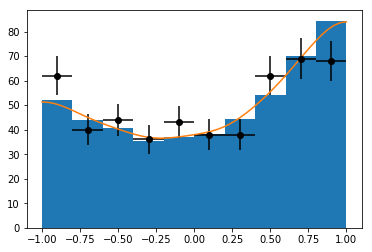

In [13]:
mc = rej_sample_costheta(10000,phi_true,theta_true)
mcweight = float(len(data))/float(len(mc))
mccounts,bins,_ =plt.hist(mc,weights = [mcweight]*len(mc), bins = np.linspace(-1,1,11))
datacounts,bins = np.histogram(data,bins = bins)
centers = bins[:-1] + (bins[1:]-bins[:-1])/2.

logmcpdf = approx_logpdf(mc,bw = 0.08)
x = np.linspace(-1,1)
plt.plot(x,len(data)*(bins[1]-bins[0])*np.exp(logmcpdf(x)))
plt.errorbar(centers,datacounts,fmt = 'o',xerr = (bins[1:]-bins[:-1])/2.,yerr = np.sqrt(datacounts), c = 'k')

In [14]:
def lnprior(theta):
    if 0.5 < theta < 1.5:
        return 0.0
    return -np.inf

def lnlike(theta, x, phi):
    mc = rej_sample_costheta(1000,phi,theta)
    logpdf = approx_logpdf(mc)
    return np.sum(logpdf(x))

def lnprob(theta, x, phi):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, phi)

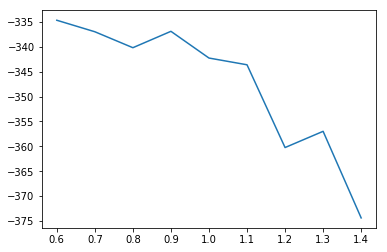

In [15]:
test_thetas = np.linspace(0.5,1.5,11)
nll = [lnprob(theta_test,data,phi_true) for theta_test in test_thetas]
plt.plot(test_thetas,nll)

In [16]:
import emcee
ndim, nwalkers = 1, 10
pos = [np.array([x]) for x in np.random.uniform(0.5,1.5,size=nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data,phi_true))
_ = sampler.run_mcmc(pos, 50)

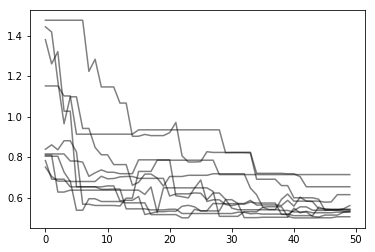

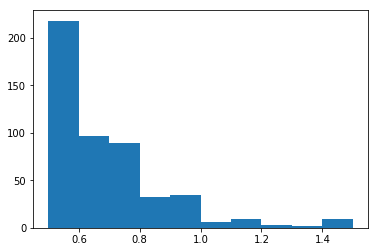

In [17]:
samples = sampler.chain
for x in samples:
    plt.plot(x, alpha = 0.5, c = 'k')
plt.show()
_=plt.hist(sampler.flatchain, bins = np.linspace(0.5,1.5,11))

In [18]:
def simulator(theta,phi,n_samples):
    return rej_sample_costheta(n_samples,phi,theta)


def collect_data(phi, n_samples = 500):
    THETA_NATURE = 1.4
    return simulator(THETA_NATURE,phi,n_samples)

In [19]:
def lnprior(theta, prior):
    p = prior.pdf(theta)
    if p <= 1e-8:
        return -np.inf
    else:
        return np.log(p)

def lnlike(theta, x, phi):
    mc = rej_sample_costheta(1000,phi,theta)
    logpdf = approx_logpdf(mc)
    return np.sum(logpdf(x))

def lnprob(theta, x, prior, phi):
    lp = lnprior(theta, prior)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, phi)

In [20]:
def calculate_posterior(prior, data, phi):
    """Compute samples from the posterior"""
    ndim, n_walkers = 1, 10
    # initialise walkers from the MAP + noise
    # XXX alternatively sample a point from the KDE without adding noise?
    # XXX not sure if the noise takes us into a region where the prior is zero?
    pos = [prior.map() + 1e-1*np.random.randn(ndim) for i in range(n_walkers)]
    
    sampler = emcee.EnsembleSampler(n_walkers, 1, lnprob, args=(data, prior, phi))
    pos, prob, state = sampler.run_mcmc(pos, 10)
    
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, 50)
    
    return Distribution(prior.name, prior.range, sampler.flatchain)

In [21]:
## initialize first prior as uniform between 0.5 and 1.5
from prior_dist import Distribution
prior_theta = Distribution('p(theta)', range=(0.5,1.5), samples=np.random.uniform(0.5, 1.5, 100000))

# Single Science Loop Body

In [22]:
phi = 47
real_data = collect_data(phi,n_samples=100)
posterior = calculate_posterior(prior_theta,real_data,phi)

MAP 1.125


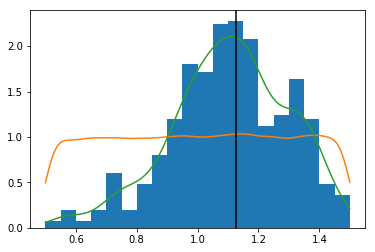

In [23]:
plt.hist(posterior.samples,normed = True,range = (0.5,1.5),bins = 20)
prior_theta.plot()
posterior.plot()
plt.axvline(posterior.map(bins = 20), c = 'k')
print 'MAP',posterior.map(bins = 20)

In [24]:
from multiprocessing import Pool

def info_gain(p1, p2):
    return p1.entropy() - p2.entropy()

def _simulate(args):
    theta_map, phi, prior = args
    print 'simulating with ',theta_map, phi
    # external workflow provides simulated data
    sim_data = simulator(theta_map, phi, n_samples = 1000)

    #external workflow uses simulator to provide likelihood 
    sim_posterior = calculate_posterior(prior, sim_data, phi)
    return info_gain(prior, sim_posterior)


def expected_information_gain(phi, prior,bins = 20):
    'calculate the expression above using workflow for simulations'
    n_simulations = 4
    
    phi = phi[0]
    #need to pass in prior through some extra arguments
    
    # use saddle-point approximation
    theta_map = prior.map(bins = bins)

    # currently the MCMC sampler is the slower part, which already uses threads so we don't gain
    # this should change once we have a more realistic simulator that takes time to run
    pool = Pool(n_simulations)
    eig = pool.map(_simulate, [(theta_map, phi, prior) for i in range(n_simulations)])
    pool.close()
    pool.join()
    return np.mean(eig)

In [30]:
eig = []
for x in np.linspace(40,50,11).reshape(-1,1):
    eig.append(expected_information_gain(x,posterior))


simulating with  1.125 40.0
simulating with  1.125 40.0
simulating with  1.125 40.0
simulating with  1.125 40.0
simulating with  1.125 41.0
simulating with  1.125 41.0
simulating with  1.125 41.0
simulating with  1.125 41.0
simulating with  1.125 42.0
simulating with  1.125 42.0
simulating with  1.125 42.0
simulating with  1.125 42.0
simulating with  1.125 43.0
simulating with  1.125 43.0
simulating with  1.125 43.0
simulating with  1.125 43.0
simulating with  1.125 44.0
simulating with  1.125 44.0
simulating with  1.125 44.0
simulating with  1.125 44.0
simulating with  1.125 45.0
simulating with  1.125 45.0
simulating with  1.125 45.0
simulating with  1.125 45.0
simulating with  1.125 46.0
simulating with  1.125 46.0
simulating with  1.125 46.0
simulating with  1.125 46.0
simulating with  1.125 47.0
simulating with  1.125 47.0
simulating with  1.125 47.0
simulating with  1.125 47.0
simulating with  1.125 48.0
simulating with  1.125 48.0
simulating with  1.125 48.0
simulating with  1.1

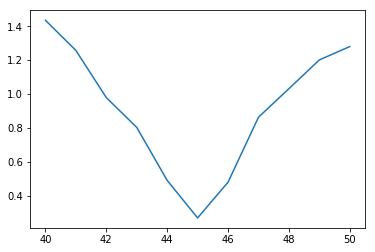

In [31]:
plt.plot(np.linspace(40,50,11),eig)

In [33]:
#use scikit-optimize to optimize phi
from skopt import gp_minimize

def design_next_experiment(prior):
    bounds = [(40,50)]
    n_calls = 10
    
    func = lambda p: -expected_information_gain(p, prior)

    # five random points to initialise things, then five using the GP model
    # XXX Should we be reusing the random number generator? Means this call eseentially evaluates
    # XXX the same values of phi each science iteration
    opt_result = gp_minimize(func, bounds, n_random_starts=5, n_calls=n_calls, random_state=4)

    return opt_result, opt_result.x[0], opt_result.x_iters

In [34]:
res = design_next_experiment(posterior)

simulating with  1.125 50
simulating with  1.125 50
simulating with  1.125 50
simulating with  1.125 50
simulating with  1.125 47
simulating with  1.125 47
simulating with  1.125 47
simulating with  1.125 47
simulating with  1.125 45
simulating with  1.125 45
simulating with  1.125 45
simulating with  1.125 45
simulating with  1.125 41
simulating with  1.125 41
simulating with  1.125 41
simulating with  1.125 41
simulating with  1.125 48
simulating with  1.125 48
simulating with  1.125 48
simulating with  1.125 48
simulating with  1.125 40
simulating with  1.125 40
simulating with  1.125 40
simulating with  1.125 40
simulating with  1.125 49
simulating with  1.125 49
simulating with  1.125 49
simulating with  1.125 49


/Users/lukas/Code/active_sciencing/venv/lib/python2.7/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


simulating with  1.125 50
simulating with  1.125 50
simulating with  1.125 50
simulating with  1.125 50
simulating with  1.125 40
simulating with  1.125 40
simulating with  1.125 40
simulating with  1.125 40
simulating with  1.125 50
simulating with  1.125 50
simulating with  1.125 50
simulating with  1.125 50


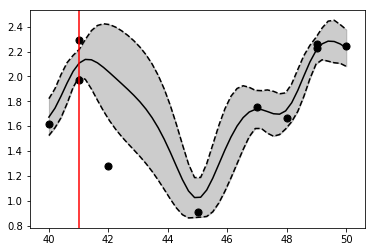

In [60]:
smoothx = np.linspace(40,50).reshape(-1,1)
y,std = res[0].models[-1].predict(smoothx, return_std = True)
y,std = -y,-std
plt.plot(smoothx[:,0],y, c = 'k')
plt.plot(smoothx[:,0],y+std, c = 'k', linestyle = 'dashed')
plt.plot(smoothx[:,0],y-std, c = 'k', linestyle = 'dashed')
plt.fill_between(smoothx[:,0],y-std,y+std, color = 'k', alpha = 0.2)
plt.scatter(res[0].x_iters,-res[0].func_vals, marker = '.', s = 200, color = 'k')
plt.axvline(res[0].x, c = 'r')

In [61]:
res[0].x_iters

[[50], [47], [45], [41], [48], [40], [49], [41], [49], [42]]